In [1]:
#Basandonos en el siguiente post: https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

# Feature Selection
### A partir de distintos algoritmos buscaremos seleccionar los features que mas informacion aportan a la prediccion del target

## Preprocesamiento

In [2]:
def limpiar_nan(col,entrenamiento,test):
    mean = entrenamiento[col].mean()
    entrenamiento[col] = entrenamiento[col].replace(np.NaN,mean)
    mean = test[col].mean()
    test[col] = test[col].replace(np.NaN,mean)
    
def limpiar_inf(col,entrenamiento,test):
    entrenamiento[col] = entrenamiento[col].replace(math.inf,np.NaN)
    test[col] = test[col].replace(math.inf,np.NaN)    

In [3]:
import Utilidades as ut
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import math


#En realidad habria que levantar un set de datos que no este destinado a redes neuronales, un 'feature_selection.pkl'

#Cargamos el dataset
df = pd.read_pickle("Archivos/Arboles_entrenamiento_exp.pkl")
df_test = pd.read_pickle("Archivos/Arboles_validacion_exp.pkl")

#df = df.drop(columns = ["Total_Product_Family_Region_Month_Change","Total_Products_Region_Week_Change","Total_Products_Region_Month_Change","Total_Products_Region_Quarter_Change"])    
#df_test = df_test.drop(columns = ["Total_Product_Family_Region_Month_Change","Total_Products_Region_Week_Change","Total_Products_Region_Month_Change","Total_Products_Region_Quarter_Change"])  

def limpiar(entrenamiento,test):
    for col in entrenamiento.columns:
        ent_null = entrenamiento.loc[entrenamiento[col] == np.inf]
        if (ent_null[col].count() > 200):
            entrenamiento.drop(columns = [col],inplace=True)
            test.drop(columns = [col],inplace=True)
        if (0<ent_null[col].count() <= 200):
            limpiar_inf(col,entrenamiento,test)        
    for col in test.columns:
        ent_null = test.loc[test[col] == np.inf]
        if (ent_null[col].count() > 200):
            entrenamiento.drop(columns = [col],inplace=True)
            test.drop(columns = [col],inplace=True)
        if (0<ent_null[col].count() <= 200):
            limpiar_inf(col,entrenamiento,test)        

    for col in entrenamiento.columns:
        ent_null = entrenamiento.loc[entrenamiento[col].isnull()]
        ent_null = ent_null.replace(np.NaN,0)
        if (ent_null[col].count() > 200):
            entrenamiento.drop(columns = [col],inplace=True)
            test.drop(columns = [col],inplace=True)
        if (0<ent_null[col].count() <= 200):
            limpiar_nan(col,entrenamiento,test)        
    for col in test.columns:
        ent_null = test.loc[test[col].isnull()]
        ent_null = ent_null.replace(np.NaN,0)
        if (ent_null[col].count() > 200):
            entrenamiento.drop(columns = [col],inplace=True)
            test.drop(columns = [col],inplace=True)
        if (0<ent_null[col].count() <= 200):
            limpiar_nan(col,entrenamiento,test)    
               
    
limpiar(df,df_test)
#Dividimos el dataframe en features-labels
df_x, df_y = ut.split_labels(df)
df_x_test, df_y_test = ut.split_labels(df_test)

#Procesamos los dataframes
df_x, df_x_test = ut.conversion_fechas(df_x, df_x_test)
df_x, df_x_test = ut.codificar_categoricas(df_x, df_y, df_x_test, modo='catboost')
df_x, df_x_test = ut.normalizacion_numericas(df_x, df_x_test, modo='normalizacion')
for col in df_x.columns:
    limpiar_inf(col,df_x,df_x_test)
    limpiar_nan(col,df_x,df_x_test)

#Convertimos el dataframe a un array de numpy
x = ut.df_a_vector(df_x)
y = ut.df_a_vector(df_y).flatten()

In [4]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12081 entries, 0 to 12080
Columns: 1670 entries, Region to Total_Taxable_Amount_Currency_Territory_Duration_std
dtypes: float64(1670)
memory usage: 153.9 MB


## Information Gain

In [5]:
importances = mutual_info_classif(x, y)
feat_importances = pd.Series(importances, df.columns[0:len(df.columns)-1])

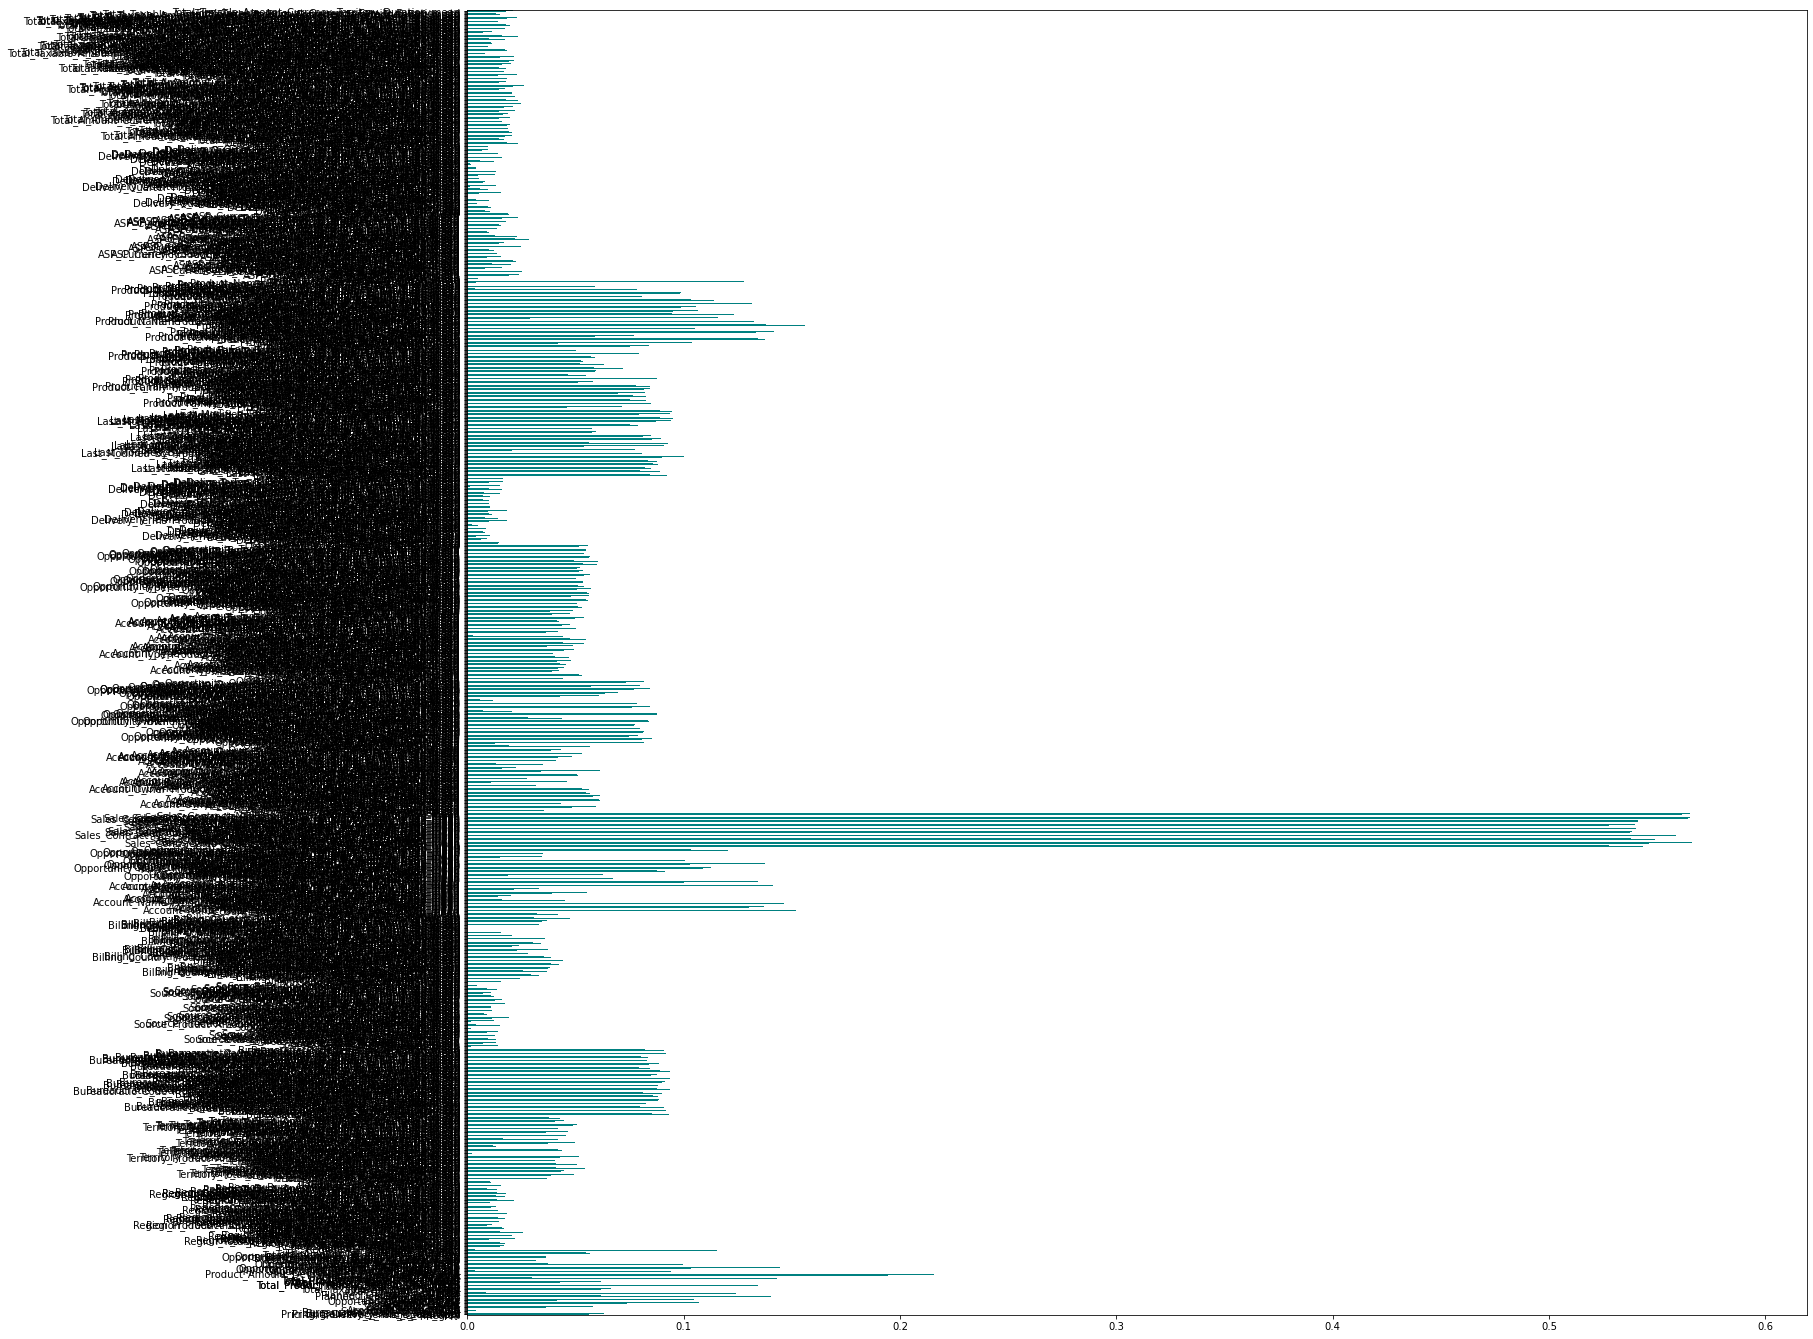

In [6]:
feat_importances.plot(kind='barh', color='teal', figsize=(24, 24))

In [7]:
features = feat_importances.to_frame()
features.columns = ['Score']
features['Score'] = (features['Score'] > features['Score'].median()).astype(int)
features

,Score
Region,1
Territory,1
"Pricing, Delivery_Terms_Quote_Appr",0
"Pricing, Delivery_Terms_Approved",0
Bureaucratic_Code_0_Approval,0
...,...
Total_Taxable_Amount_Currency_Buro_Approved_by_Product_Family_mean,0
Total_Taxable_Amount_Currency_Buro_Approved_by_Product_Family_std,0
Total_Taxable_Amount_Currency_Family_Duration_mean,0
Total_Taxable_Amount_Currency_Family_Duration_std,0


## Fisher's Score

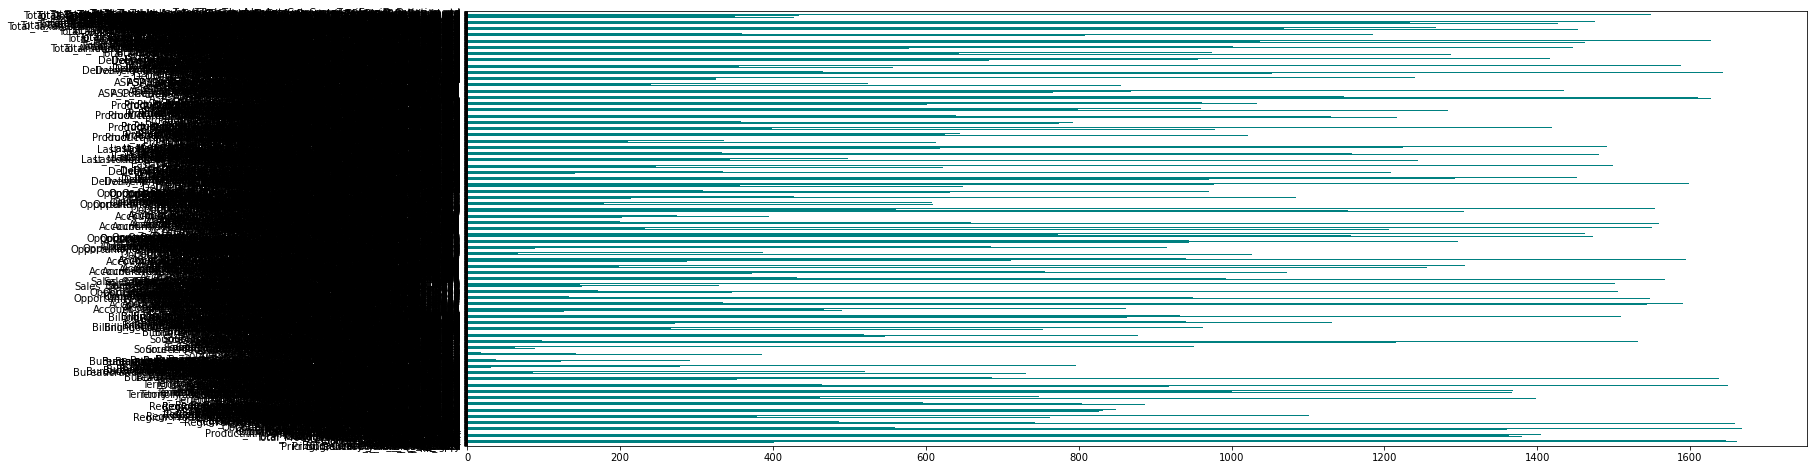

In [8]:
from skfeature.function.similarity_based import fisher_score

ranks = fisher_score.fisher_score(x, y)
feat_importances = pd.Series(ranks, df.columns[0:len(df.columns) - 1])
feat_importances.plot(kind='barh', color='teal', figsize=(24, 8))

In [9]:
actual = (feat_importances > feat_importances.median()).astype(int)
features['Score'] = features['Score'] + actual
features

,Score
Region,2
Territory,2
"Pricing, Delivery_Terms_Quote_Appr",1
"Pricing, Delivery_Terms_Approved",1
Bureaucratic_Code_0_Approval,1
...,...
Total_Taxable_Amount_Currency_Buro_Approved_by_Product_Family_mean,0
Total_Taxable_Amount_Currency_Buro_Approved_by_Product_Family_std,1
Total_Taxable_Amount_Currency_Family_Duration_mean,1
Total_Taxable_Amount_Currency_Family_Duration_std,0


## Correlation Coefficient

In [15]:
import seaborn as sns

#Damos un punto extra por cada threshold

thresholds = [0.1, 0.2, 0.3, 0.4]
df_x = df_x.drop(columns = ['Total_Taxable_Amount_Currency_Territory_Duration_std'])
combined = df_x.copy()
combined['Stage'] = df_y['Stage']

cor = combined.corr()
#plt.figure(figsize = (24, 24))
#sns.heatmap(cor, annot=True)
cor = cor.drop(index=['Stage'])[['Stage']]

for t in thresholds:
    index = cor[np.abs(cor.Stage) > t].index
    features.loc[index,['Score']] = features.reindex(index = index, columns =['Score']) + 1

## Variance Threshold

In [16]:
from sklearn.feature_selection import VarianceThreshold

#Con threshold elegimos el valor de la varianza a partir de la cual queremos marcar a las columnas como "varianza cero"
v_t = VarianceThreshold(threshold=0)
#Procesamos con el dataset de train
v_t.fit(x)
#Obtenemos una serie de pandas donde cada fila indica si el feature tiene (True) o no tiene (False) varianza superior al threshold
result = pd.Series(v_t.get_support())
result.index = features['Score'].index
features['Score'] = features['Score'] + result.copy()

In [17]:
features.nlargest(40, columns='Score')["Score"].index.tolist()

['Bureaucratic_Code',
 'Account_Name',
 'Sales_Contract_No',
 'Opportunity_Owner',
 'Last_Modified_By',
 'Product_Family',
 'Product_Name',
 'Planned_Opportunity_Duration',
 'Opportunity_Name_Planned_Opportunity_Duration_mean',
 'Sales_Contract_No_Opportunity_TRF_Region_std_Ratio_mean',
 'Product_Name_Planned_Time_Until_Deliver_mean',
 'Territory',
 'Billing_Country',
 'Opportunity_Name',
 'Account_Owner',
 'Account_Type',
 'Planned_Time_Until_Deliver',
 'Bureaucratic_Code_ASP_mean',
 'Bureaucratic_Code_Total_Amount_std',
 'Bureaucratic_Code_Total_Amount(USD)_std',
 'Bureaucratic_Code_Total_Products_Region_Last_Week_mean',
 'Bureaucratic_Code_Total_Products_Region_Last_Quarter_mean',
 'Bureaucratic_Code_Planned_Deliver_Duration_std',
 'Bureaucratic_Code_Actual_Opportunity_Duration_std',
 'Bureaucratic_Code_Planned_Time_Until_Deliver_std',
 'Bureaucratic_Code_Planned_Opportunity_Duration_mean',
 'Bureaucratic_Code_Product_Amount_Deviation_of_Product_Family_rate_std',
 'Bureaucratic_Code